In [167]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from Variance_reduction import montecarlo, montecarlo_estimators, plot_variance_ratios
from scipy.stats import skew, kurtosis

In [168]:
# tickers = [
#     "AAPL", "MSFT", "TSLA", "NVDA",  # Big caps
#     "SHOP.TO", "TWLO", "ETSY",       # small/mid caps
#     "ARKK",                           # ETF sectorial
#     "GC=F", "NG=F"                    # Gold / Gas
# ]

# data = yf.download(tickers, start="2018-01-01", end="2023-12-31", auto_adjust=True)
# S = data['Close']
# S.to_excel("prix_actifs.xlsx", index=True)

In [169]:
S = pd.read_excel("prix_actifs.xlsx", index_col="Date", parse_dates=True)

rename_dict = {
    "GC=F": "GOLD",
    "NG=F": "GAS",
    "SHOP.TO": "SHOP"
}

S.rename(columns=rename_dict, inplace=True)

# S = S.drop("GOLD", axis = 1)
# S = S.drop(S.columns[:6], axis=1)

In [170]:
S.head()

,AAPL,ARKK,ETSY,GOLD,MSFT,GAS,NVDA,SHOP,TSLA,TWLO
Date,,,,,,,,,,
2018-01-02,40.380997,36.053844,20.83,1313.699951,79.328537,3.056,4.929085,13.206,21.368668,25.100000
2018-01-03,40.373959,36.203369,20.41,1316.199951,79.697701,3.008,5.253487,13.515,21.150000,25.690001
2018-01-04,40.561497,36.324852,20.23,1319.400024,80.399162,2.880,5.281182,13.746,20.974667,25.680000
2018-01-05,41.023296,36.913609,20.25,1320.300049,81.395966,2.795,5.325935,13.726,21.105333,25.760000
2018-01-08,40.870937,36.661282,20.32,1318.599976,81.479050,2.835,5.489125,13.951,22.427334,26.170000


In [171]:
total_days = (S.index.max() - S.index.min()).days + 1

print(S.isna().sum())
print(f"The number of trading days : {total_days}")

AAPL    28
ARKK    28
ETSY    28
GOLD    29
MSFT    28
GAS     27
NVDA    28
SHOP    32
TSLA    28
TWLO    28
dtype: int64
The number of trading days : 2188


In [172]:
S.interpolate(method='linear', inplace=True)

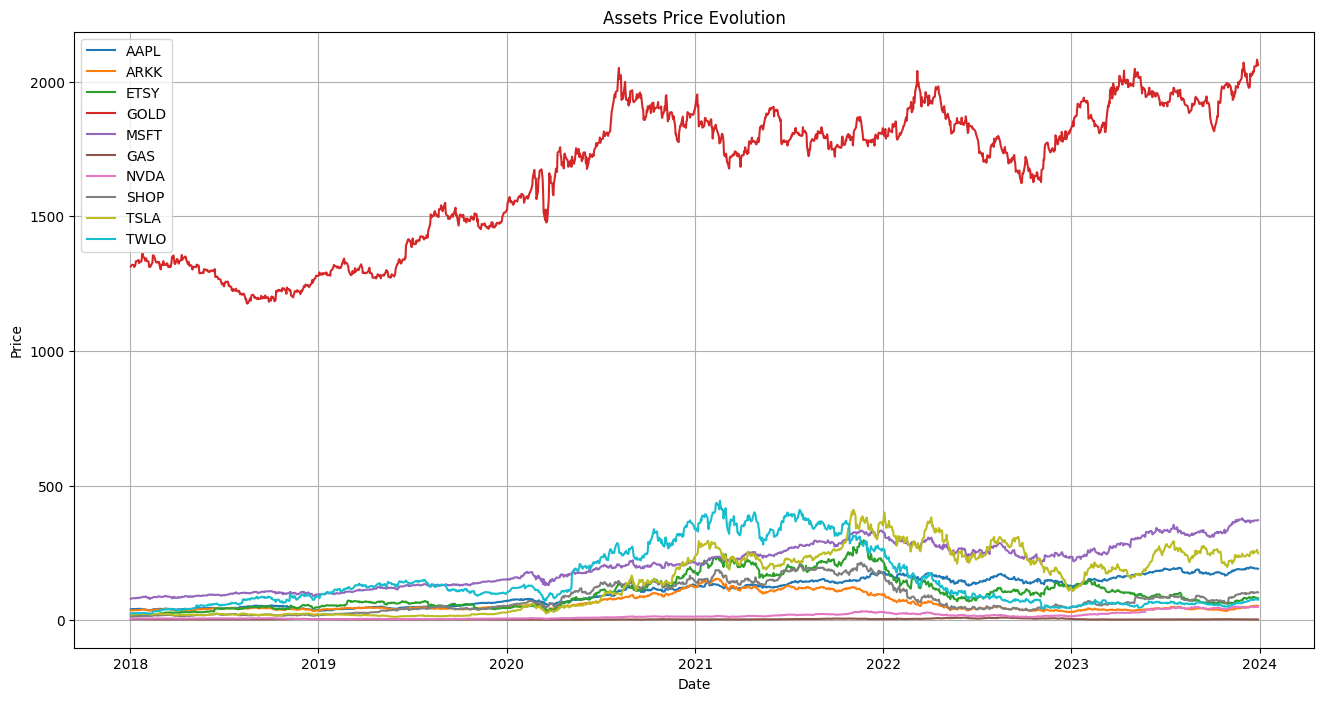

In [173]:
plt.figure(figsize=(16, 8))

for col in S.columns:
    plt.plot(S.index, S[col], label=col)


plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Assets Price Evolution')
plt.legend()
plt.grid(True)
plt.show()

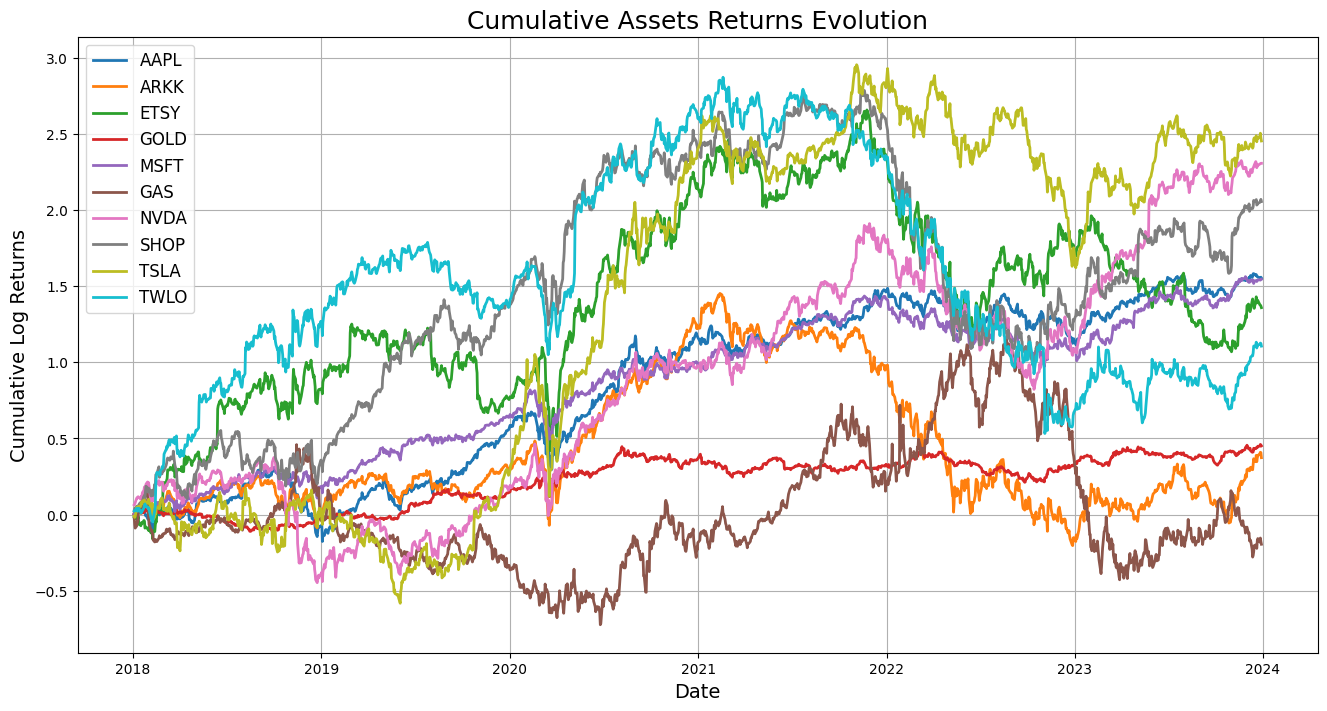

In [174]:
returns = np.log(S / S.shift(1))

# Cumulative returns
cum_returns = returns.cumsum()

plt.figure(figsize=(16, 8))

for col in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[col], label=col, linewidth=2)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Log Returns', fontsize=14)
plt.title('Cumulative Assets Returns Evolution', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [175]:
#We check if any value was 0
returns.isna().sum()

AAPL    1
ARKK    1
ETSY    1
GOLD    1
MSFT    1
GAS     1
NVDA    1
SHOP    1
TSLA    1
TWLO    1
dtype: int64

In [176]:
returns = returns.dropna()

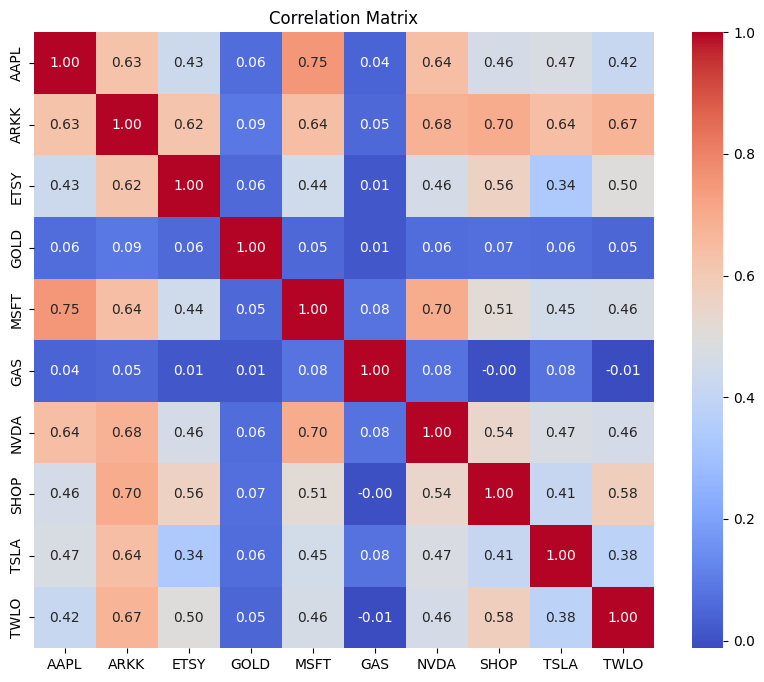

In [177]:
cov_matrix = returns.cov()
sigma = np.sqrt(np.diag(cov_matrix)) * np.sqrt(252)
corr_matrix =  returns.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### Experimental Study

In the following section, we will perform a simulation study in order to test and compare the different estimators introduced previously.  
The objective is to evaluate their relative performance in terms of variance reduction and computational efficiency,  
and to identify under which conditions each method provides the greatest benefit.

In [178]:
N = 10000
r = 0.05
T = 1
K = 100
R = corr_matrix
d = returns.columns.size
cov = corr_matrix.values * T
S0 = S.iloc[-1].values
w = np.ones(d) /d
proba = 0.95 #It indicates the probability that the derivative’s price lies within the confidence interval.

In [179]:
MC, VC, NVC, NVC_C, A, G, timings = montecarlo_estimators(N, d, S0, sigma, r, T, K, w, R, False, True)

In [180]:
monte_carlo_estimator, asymptotic_variance, bound = montecarlo(MC, proba, with_interval_bounds = True)
monte_carlo_estimator_VC, asymptotic_variance_VC, bound = montecarlo(VC, proba, with_interval_bounds = True)
monte_carlo_estimator_NVC, asymptotic_variance_NVC, bound = montecarlo(NVC, proba, with_interval_bounds = True)
monte_carlo_estimator_NVC_C, asymptotic_variance_NVC_C, bound = montecarlo(NVC_C, proba, with_interval_bounds = True)

var_ratio = np.array([asymptotic_variance / asymptotic_variance_VC, asymptotic_variance/ asymptotic_variance_NVC, asymptotic_variance/ asymptotic_variance_NVC_C])
effort = np.array([asymptotic_variance, asymptotic_variance_VC, asymptotic_variance_NVC, asymptotic_variance_NVC_C]) * timings
effort_ratio = np.array([effort[0] / effort[1], effort[0] / effort[2], effort[0] / effort[3]])

print("Variance ratio MC/VC : ", var_ratio[0])
print("Variance ratio MC/NVC : ", var_ratio[1])
print("Variance ratio MC/NVC_C : ", var_ratio[2])

print("Effort ratio MC/VC : ", effort_ratio[0])
print("Effort ratio MC/NVC : ", effort_ratio[1])
print("Effort ratio MC/NVC_C : ", effort_ratio[2])



Variance ratio MC/VC :  1.8178300416959448
Variance ratio MC/NVC :  0.29116654275717285
Variance ratio MC/NVC_C :  0.3440063283229594
Effort ratio MC/VC :  0.1588276793096742
Effort ratio MC/NVC :  0.026446612408732053
Effort ratio MC/NVC_C :  0.008277632415308602


We did not at all expect these preliminary results: the efficiency of the estimators, for both indicators, decreases, whereas we had anticipated the opposite. In fact, this can be easily explained by the fact that the prices of the different assets vary significantly, causing A and G to take drastically different values in terms of magnitude. 

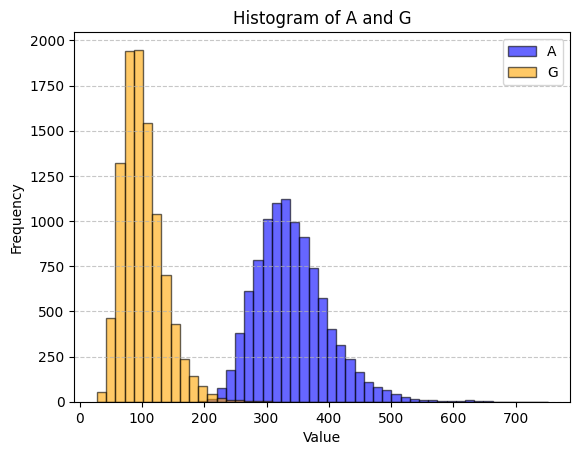

In [181]:
bins = np.linspace(min(A.min(), G.min()), max(A.max(), G.max()), 50)

plt.hist(A, bins=bins, alpha=0.6, label='A', color='blue', edgecolor='black')
plt.hist(G, bins=bins, alpha=0.6, label='G', color='orange', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of A and G')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [182]:
print("A skew:", skew(A), "G skew:", skew(G))
print("A kurt:", kurtosis(A), "G kurt:", kurtosis(G))

A skew: 0.8635135768536627 G skew: 1.1134874272138073
A kurt: 1.70026435934337 G kurt: 2.3039005641792683


A and G have similar shapes but different levels, so their supports barely overlap. With 
$$K = 100$$
, A is almost always above K, while G is above K about half the time. Since the control variates 
$$(G-K)^+$$ 
and Curran's 
$$(A-K)^+ \mathbf{1}_{\{G>K\}}$$ 
are less correlated with the underlying payoff, these methods become less effective. This difference arises because, in a basket of assets with very different prices, the logarithm flattens large values and G grows more slowly than A.


Now, we will lowered K, to verify what have been said previously


In [183]:
K = 40

In [184]:
MC, VC, NVC, NVC_C, A, G, timings = montecarlo_estimators(N, d, S0, sigma, r, T, K, w, R, False, True)

monte_carlo_estimator, asymptotic_variance, bound = montecarlo(MC, proba, with_interval_bounds = True)
monte_carlo_estimator_VC, asymptotic_variance_VC, bound = montecarlo(VC, proba, with_interval_bounds = True)
monte_carlo_estimator_NVC, asymptotic_variance_NVC, bound = montecarlo(NVC, proba, with_interval_bounds = True)
monte_carlo_estimator_NVC_C, asymptotic_variance_NVC_C, bound = montecarlo(NVC_C, proba, with_interval_bounds = True)

var_ratio = np.array([asymptotic_variance / asymptotic_variance_VC, asymptotic_variance/ asymptotic_variance_NVC, asymptotic_variance/ asymptotic_variance_NVC_C])
effort = np.array([asymptotic_variance, asymptotic_variance_VC, asymptotic_variance_NVC, asymptotic_variance_NVC_C]) * timings
effort_ratio = np.array([effort[0] / effort[1], effort[0] / effort[2], effort[0] / effort[3]])

print("Variance ratio MC/VC : ", var_ratio[0])
print("Variance ratio MC/NVC : ", var_ratio[1])
print("Variance ratio MC/NVC_C : ", var_ratio[2])

print("Effort ratio MC/VC : ", effort_ratio[0])
print("Effort ratio MC/NVC : ", effort_ratio[1])
print("Effort ratio MC/NVC_C : ", effort_ratio[2])


Variance ratio MC/VC :  2.5264682874373836
Variance ratio MC/NVC :  34.21851689500151
Variance ratio MC/NVC_C :  43.9670974886549
Effort ratio MC/VC :  0.16929447711947537
Effort ratio MC/NVC :  2.3003497360379987
Effort ratio MC/NVC_C :  0.7015497633004194


In this part, we remove GOLD, GAS, ARKK and NVDA (to reduce the price differences)

In [185]:
S_mod = S.drop(["GOLD", "GAS", "NVDA", "ARKK"], axis = 1)
returns_mod  = returns.drop(["GOLD", "GAS", "NVDA", "ARKK"], axis = 1)

In [186]:
cov_matrix_mod = returns_mod.cov()
sigma = np.sqrt(np.diag(cov_matrix_mod)) * np.sqrt(252)
corr_matrix_mod =  returns_mod.corr()

In [187]:
R = corr_matrix_mod
d = returns_mod.columns.size
cov = corr_matrix_mod.values * T
S0 = S_mod.iloc[-1].values
w = np.ones(d) /d


In [188]:
MC, VC, NVC, NVC_C, A, G, timings = montecarlo_estimators(N, d, S0, sigma, r, T, K, w, R, False, True)

monte_carlo_estimator, asymptotic_variance, bound = montecarlo(MC, proba, with_interval_bounds = True)
monte_carlo_estimator_VC, asymptotic_variance_VC, bound = montecarlo(VC, proba, with_interval_bounds = True)
monte_carlo_estimator_NVC, asymptotic_variance_NVC, bound = montecarlo(NVC, proba, with_interval_bounds = True)
monte_carlo_estimator_NVC_C, asymptotic_variance_NVC_C, bound = montecarlo(NVC_C, proba, with_interval_bounds = True)

var_ratio = np.array([asymptotic_variance / asymptotic_variance_VC, asymptotic_variance/ asymptotic_variance_NVC, asymptotic_variance/ asymptotic_variance_NVC_C])
effort = np.array([asymptotic_variance, asymptotic_variance_VC, asymptotic_variance_NVC, asymptotic_variance_NVC_C]) * timings
effort_ratio = np.array([effort[0] / effort[1], effort[0] / effort[2], effort[0] / effort[3]])

print("Variance ratio MC/VC : ", var_ratio[0])
print("Variance ratio MC/NVC : ", var_ratio[1])
print("Variance ratio MC/NVC_C : ", var_ratio[2])

print("Effort ratio MC/VC : ", effort_ratio[0])
print("Effort ratio MC/NVC : ", effort_ratio[1])
print("Effort ratio MC/NVC_C : ", effort_ratio[2])


Variance ratio MC/VC :  10.727556269637326
Variance ratio MC/NVC :  16268.126033103494
Variance ratio MC/NVC_C :  21647.594825126438
Effort ratio MC/VC :  0.9733629330916934
Effort ratio MC/NVC :  1135.3574197414955
Effort ratio MC/NVC_C :  348.19238797447093


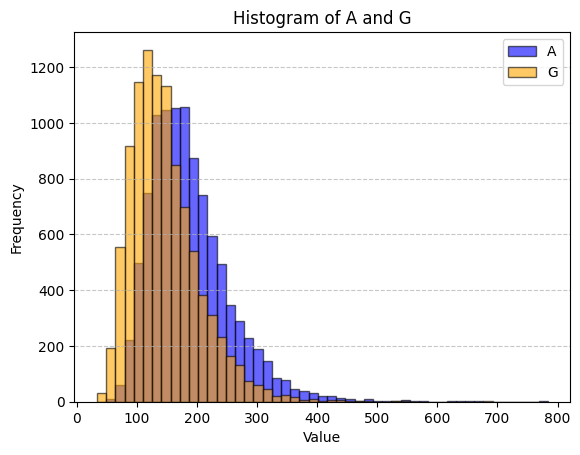

In [189]:
bins = np.linspace(min(A.min(), G.min()), max(A.max(), G.max()), 50)

plt.hist(A, bins=bins, alpha=0.6, label='A', color='blue', edgecolor='black')
plt.hist(G, bins=bins, alpha=0.6, label='G', color='orange', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of A and G')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [190]:
print("A skew:", skew(A), "G skew:", skew(G))
print("A kurt:", kurtosis(A), "G kurt:", kurtosis(G))

A skew: 1.3058384651597361 G skew: 1.2934426356450377
A kurt: 3.48504505049986 G kurt: 3.367973065093709
